## AMP prescribing as recommended by the [NHS Dictionary of medicines and devices](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/)

**THIS IS A WORK IN PROGRESS**

The UK has over the last few decades encouraged generic prescribing for reasons of cost containment and safety. However there are important exceptions where generic prescribing is not ideal e.g. narrow therapeutic index where even slight variations between brands could cause adverse clinical responses. On OpenPrescribing we have some measures of generic prescribing where brand prescribing is recommended 

- [ciclosporin and tacrolimus](https://openprescribing.net/measure/ciclosporin/)
- [diltiazem >60mg](https://openprescribing.net/measure/diltiazem/)

We have found that [12.3% of prescriptions for diltiazem, tacrolimus and ciclosporin breach prescribing guidance](https://openprescribing.net/measure/diltiazem/) on brand prescribing in a paper accted in JMIR. 

Various organisations make recommendations about brand prescribing in the NHS including the [NHS dictionary of medicines and devices (dm+d)](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/) which is the mandated drug dictionary for electronic systems in the NHS. In the field `prescribing status` the dm+d can assign a value `caution - AMP level prescribing advised` which means you should prescribe by brand. This is assigned to 229 VMPs.

In this notebook we will set out to investigate brand prescribing across all products.

In [1]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

In [2]:
sql = '''
SELECT
  month,
  pct,
  bnf_name,
  bnf_code,
  SUM(items) AS total_items
FROM
hscic.normalised_prescribing_standard AS rx
INNER JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4 
  AND  
  ccgs.org_type='CCG'
  AND
  bnf_code IN (
  SELECT
    DISTINCT(bnf_code)
  FROM
    ebmdatalab.brian.amp_recommended
     )
GROUP BY
rx.month,
rx.pct,
rx.bnf_code,
rx.bnf_name
ORDER BY
month
'''

df_amp_recommended = bq.cached_read(sql, csv_path=os.path.join('..','data','df_amp_recommended.zip'))
#df_amp_recommended = bq.cached_read(sql, csv_path=os.path.join('..','data','df_amp_recommended.csv'))
df_amp_recommended['month'] = df_amp_recommended['month'].astype('datetime64[ns]')
df_amp_recommended.head(3)

,month,pct,bnf_name,bnf_code,total_items
0,2010-08-01,06F,Beclomet Diprop_Inha B/A 50mcg(200 D)CFF,0302000C0AABGBG,1
1,2010-08-01,03L,Calcicard CR_Tab 90mg,0206020C0BCACAC,2
2,2010-08-01,03F,Buprenorphine_Patch 70mcg/hr (96hr),0407020B0AAAGAG,11


(0, 5686891.5)

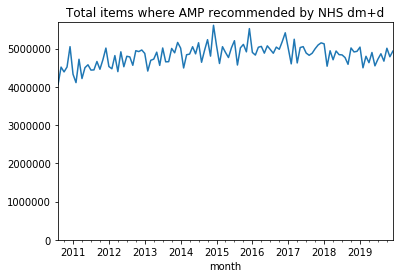

In [3]:
#lets graph to see the total number of items over time
df_amp_recommended.groupby("month")['total_items'].sum().plot(kind='line', title="Total items where AMP recommended by NHS dm+d")
plt.ylim(0, )

In [4]:
#create dataframe with only generically prescribed items
df_generic = df_amp_recommended.loc[df_amp_recommended["bnf_code"].str.contains('AA\w{4}$')]
df_generic.head()

,month,pct,bnf_name,bnf_code,total_items
0,2010-08-01,06F,Beclomet Diprop_Inha B/A 50mcg(200 D)CFF,0302000C0AABGBG,1
2,2010-08-01,03F,Buprenorphine_Patch 70mcg/hr (96hr),0407020B0AAAGAG,11
4,2010-08-01,99M,Ciclosporin_Cap 50mg,0802020G0AAAFAF,4
5,2010-08-01,08F,Enoxaparin_Inj 150mg/ml 1ml Pfs,0208010D0AAAGAG,1
6,2010-08-01,12F,Methylphenidate HCl_Cap 10mg M/R,0404000M0AAAUAU,2


In [5]:
#output unique BNF codes to inspect for accuracy
df_generic.bnf_code.unique()

array(['0302000C0AABGBG', '0407020B0AAAGAG', '0802020G0AAAFAF',
       '0208010D0AAAGAG', '0404000M0AAAUAU', '0407020ADAAAFAF',
       '0905022S0AAABAB', '0802020T0AAAFAF', '0408010C0AAAPAP',
       '0206020C0AAATAT', '0802020T0AAAAAA', '0301011R0AAAQAQ',
       '0404000M0AAAQAQ', '0302000N0AABFBF', '0206020C0AAAWAW',
       '0304030C0AAA3A3', '0301011E0AAACAC', '040702040AAADAD',
       '0302000N0AABGBG', '0802020G0AAACAC', '0206020C0AAAVAV',
       '0601012X0AAABAB', '0206020R0AAAPAP', '0407020Q0AAEHEH',
       '0601011A0AAACAC', '0208010D0AAAAAA', '0302000C0AABVBV',
       '0601011A0AAABAB', '0402030K0AAAFAF', '040702040AAACAC',
       '0302000K0AAAKAK', '0408010Q0AAADAD', '0302000C0AABEBE',
       '0407020ADAAAHAH', '0601011L0AAABAB', '0301011R0AABUBU',
       '0206020R0AAANAN', '0408010C0AAACAC', '0208010D0AAAEAE',
       '0302000C0AABHBH', '0402030K0AAAGAG', '0302000C0AABWBW',
       '0206020R0AAAEAE', '0301030C0AAAEAE', '0302000K0AAAHAH',
       '0208010D0AAAFAF', '0302000K0AAAU

(0, 2312111.2)

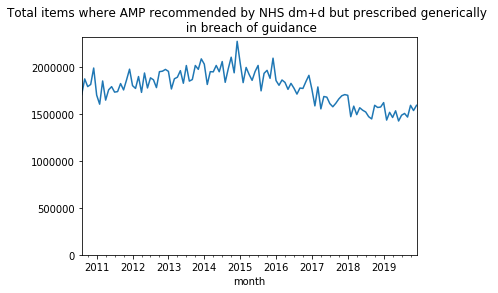

In [6]:
#plot breaches
df_generic.groupby("month")['total_items'].sum().plot(kind='line', title="Total items where AMP recommended by NHS dm+d but prescribed generically \n in breach of guidance")
plt.ylim(0, )

In [7]:
#inspect top 25
df_generic.groupby(['bnf_code', 'bnf_name']).sum().reset_index().sort_values(by = 'total_items', ascending = False).head(25)

,bnf_code,bnf_name,total_items
26,0301011R0AAAPAP,Salbutamol_Inha 100mcg (200 D) CFF,101747921
28,0301011R0AABUBU,Salbutamol_Inha B/A 100mcg (200 D) CFF,8744787
55,0302000N0AABGBG,Fluticasone/Salmeterol_Inh 250/25mcg120D,7906358
54,0302000N0AABFBF,Fluticasone/Salmeterol_Inh 125/25mcg120D,6326069
47,0302000K0AAAMAM,Budesonide/Formoterol Inh B/A 200/6(120D,6094414
52,0302000N0AAAZAZ,Fluticasone/Salmeterol_Inh 500/50mcg 60D,5702140
29,0301011U0AAAHAH,Salmeterol_Inha 25mcg (120 D) CFF,4951326
49,0302000K0AAAUAU,Budesonide/Formoterol Inh B/A 400/12(60D,3673620
108,0408010Q0AAAAAA,Phenytoin_Sod Cap 100mg,3475727
99,0408010C0AAACAC,Carbamazepine_Tab 200mg,3161450


In [8]:
df_generic_ccg = df_generic.groupby(['month', 'pct']).sum().reset_index()
df_generic_ccg .head(3)

,month,pct,total_items
0,2010-08-01,00L,14741
1,2010-08-01,00N,8976
2,2010-08-01,00P,9402


In [9]:
df_amp_recommended_ccg = df_amp_recommended.groupby(['month', 'pct']).sum().reset_index()
df_amp_recommended_ccg.head(3)

,month,pct,total_items
0,2010-08-01,00L,33072
1,2010-08-01,00N,16555
2,2010-08-01,00P,29974


In [10]:
df_measure = pd.merge(df_generic_ccg, df_amp_recommended_ccg,  how='left', left_on=['month','pct'], right_on = ['month','pct'], suffixes=("_generic_rx", "_all_rx_rec_amp"))
df_measure["measure_value"] = 100*(df_measure.total_items_generic_rx / df_measure.total_items_all_rx_rec_amp).fillna(0)
df_measure.head()


,month,pct,total_items_generic_rx,total_items_all_rx_rec_amp,measure_value
0,2010-08-01,00L,14741,33072,44.572448
1,2010-08-01,00N,8976,16555,54.219269
2,2010-08-01,00P,9402,29974,31.367185
3,2010-08-01,00Q,8830,16299,54.175103
4,2010-08-01,00R,10203,16690,61.132415


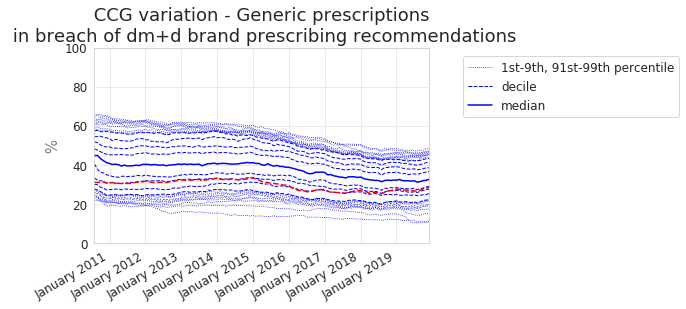

In [11]:
charts.deciles_chart(
    df_measure,
    period_column='month',
    column='measure_value',
    title=" CCG variation - Generic prescriptions \n in breach of dm+d brand prescribing recommendations",
    ylabel=" % ",
    show_outer_percentiles=True,
    show_legend=True
) 

#add in example CCG (Devon)
df_subject = df_measure.loc[df_measure['pct'] == '15N']
plt.plot(df_subject['month'], df_subject['measure_value'], 'r--')

plt.ylim(0, 100)
plt.show()

/root/.pyenv/versions/3.8.1/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


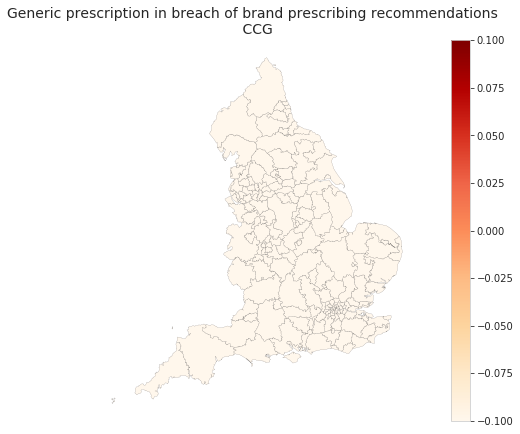

In [12]:
#create choropeth map 
plt.figure(figsize=(12, 7))
last_year_df_measure = df_measure.loc[(df_measure['month'] >= '2020-04-01') & (df_measure['month'] <= '2020-12-01')]
plt = maps.ccg_map(last_year_df_measure, title="Generic prescription in breach of brand prescribing recommendations  \n CCG ", column='measure_value', separate_london=False)
plt.show()